In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [27]:
df = pd.read_csv('diabetic_data.csv')

clean = df.replace('?',np.nan)
clean = clean.drop(['encounter_id','patient_nbr'], axis = 1)
clean['readmitted'] = clean['readmitted'].apply(lambda x: 'YES' if x != 'NO' else 'NO')

In [28]:
# Identify columns with missing data
missing_data = clean.isnull().sum()

# Filter columns with missing data more than 0
missing_columns = missing_data[missing_data > 0]

# Calculate the percentage of missing values
total_rows = len(clean)
missing_columns_percentage = (missing_columns / total_rows) * 100

# Create a DataFrame to hold the results
missing_info_df = pd.DataFrame({'Column Name': missing_columns.index, 'Missing Values': missing_columns.values, 'Percentage': missing_columns_percentage.values})
missing_info_df['Percentage'] = missing_info_df['Percentage'].apply(lambda x: '{:.2f}%'.format(x))

missing_info_df

,Column Name,Missing Values,Percentage
0,race,2273,2.23%
1,weight,98569,96.86%
2,payer_code,40256,39.56%
3,medical_specialty,49949,49.08%
4,diag_1,21,0.02%
5,diag_2,358,0.35%
6,diag_3,1423,1.40%
7,max_glu_serum,96420,94.75%
8,A1Cresult,84748,83.28%


In [29]:
# 0. Impute race with mode
mode_race = clean['race'].mode()[0]
clean['race'].fillna(mode_race, inplace=True)

# 1. Drop weight column
clean.drop('weight', axis=1, inplace=True)

# 2. Impute payer_code with 'UNKNOWN'
clean['payer_code'].fillna('UNKNOWN', inplace=True)

# 3. Impute medical_specialty with 'UNKNOWN'
clean['medical_specialty'].fillna('UNKNOWN', inplace=True)

# 4,5,6. Impute diag_1, diag_2, and diag_3 with 0
for col in ['diag_1', 'diag_2', 'diag_3']:
    clean[col].fillna(0, inplace=True)

# 7,8. Drop max_glu_serum and A1Cresult columns
clean.drop(['max_glu_serum', 'A1Cresult'], axis=1, inplace=True)

In [17]:
clean.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [18]:
clean.shape

(101766, 48)

In [5]:
clean.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [6]:
# 1. Data Pre-processing
# Drop the target column and set up X and y
X = clean.drop('readmitted', axis=1)
y = clean['readmitted']

# Convert categorical columns to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7337)

In [7]:
print(X.shape)

(101766, 2415)


In [8]:
# 2. Train a Logistic Regression Model
model = LogisticRegression(max_iter = 100, n_jobs=-1)
model.fit(X_train, y_train)

# 3. Evaluate the Model
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label="YES")}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label="YES")}')
print(f'F1-Score: {f1_score(y_test, y_pred, pos_label="YES")}')

Accuracy: 0.6262364886996397
Precision: 0.6392564587271582
Recall: 0.4328379435397853
F1-Score: 0.5161755352978589


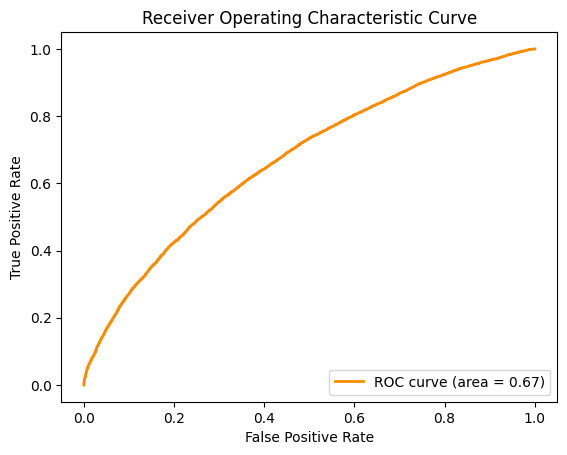

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label="YES")
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

       Coefficient  Abs_Coefficient
count  2415.000000      2415.000000
mean     -0.000360         0.006546
std       0.022085         0.021095
min      -0.197550         0.000000
25%      -0.001624         0.000459
50%      -0.000355         0.001146
75%       0.000705         0.003510
max       0.346405         0.346405


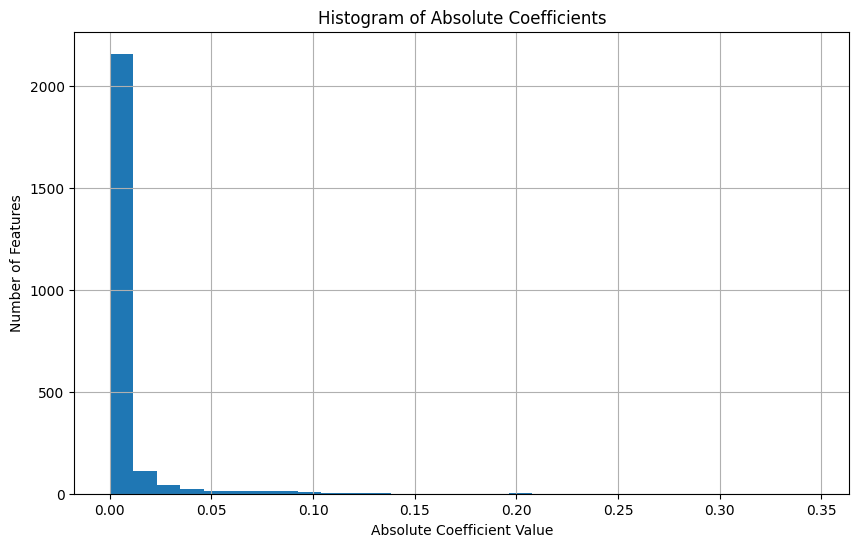

In [10]:
# Display the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Mapping coefficients to their respective features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients[0]
}).sort_values(by='Coefficient', ascending=False)


# Convert coefficients to absolute values
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

print(feature_importance.describe())

# Plot histogram of absolute coefficients
plt.figure(figsize=(10, 6))
feature_importance['Abs_Coefficient'].hist(bins=30)
plt.title('Histogram of Absolute Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Number of Features')
plt.grid(True)
plt.show()

In [11]:
filtered_features = feature_importance[feature_importance['Abs_Coefficient'] >= .003510]
selected_features = filtered_features['Feature'].tolist()

In [12]:
# 5. Train and Evaluate the Model with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model_selected = LogisticRegression(max_iter=100, n_jobs=-1)
model_selected.fit(X_train_selected, y_train)

y_pred_selected = model_selected.predict(X_test_selected)

print(f'Accuracy (Selected Features): {accuracy_score(y_test, y_pred_selected)}')
print(f'Precision (Selected Features): {precision_score(y_test, y_pred_selected, pos_label="YES")}')
print(f'Recall (Selected Features): {recall_score(y_test, y_pred_selected, pos_label="YES")}')
print(f'F1-Score (Selected Features): {f1_score(y_test, y_pred_selected, pos_label="YES")}')

Accuracy (Selected Features): 0.6306256141500164
Precision (Selected Features): 0.6361681329423264
Recall (Selected Features): 0.462774656901088
F1-Score (Selected Features): 0.535792203515416


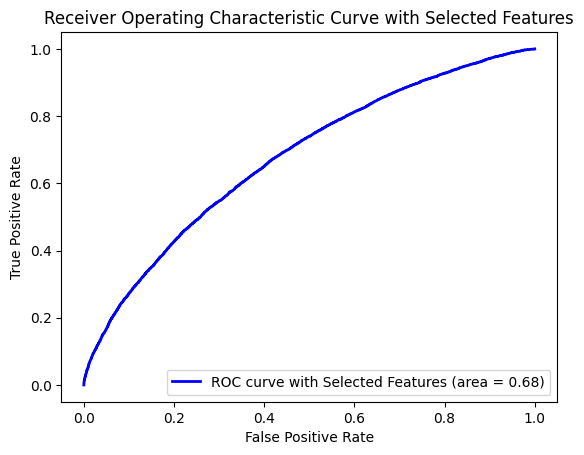

In [13]:
fpr_selected, tpr_selected, thresholds_selected = roc_curve(y_test, model_selected.predict_proba(X_test_selected)[:,1], pos_label="YES")
plt.figure()
plt.plot(fpr_selected, tpr_selected, color='blue', lw=2, label='ROC curve with Selected Features (area = %0.2f)' % auc(fpr_selected, tpr_selected))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with Selected Features')
plt.legend(loc="lower right")
plt.show()